# Classificação e BB para o MultMNIST - MultScale
* Dowloand dos pacotes e bibliotecas
* Criação do dataset e dataloader para os dados de treinamento
* Target cusumizado utilizando uma gausiana
* Criação de uma rede totalmente convolucional para comportar qualquer tamanho de entrada
* Treinamento com imagens e targets 28x28
* Comparação entre funções de custo MSE e CrossEntropy
* Predição de imagens de qualquer tamanho com multiplos digitos


## 1 - Dowloands e configurações

### 1.1 - Dowloands

In [1]:
!wget -nc -q https://raw.githubusercontent.com/robertoalotufo/files/master/lib/pytorch_trainer_v2.py -Plib/

### 1.2 - Importando os módulos

In [2]:
GOOGLE_COLAB = False

if GOOGLE_COLAB:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip3 install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

    # PIL workaround 
    from PIL import Image
    def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
    Image.register_extension = register_extension
    def register_extensions(id, extensions): 
        for extension in extensions: register_extension(id, extension)
    Image.register_extensions = register_extensions

!nvidia-smi


# Standard libs
import time
import os
import copy
import pickle
from math import sqrt, pow
import traceback
from random import random
from collections import OrderedDict
import multiprocessing as mp

# 3rd party libs
from PIL import Image
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torchvision import transforms

from lib import pytorch_trainer_v2 as ptt
        
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
   
  
from sklearn.model_selection import train_test_split

print("Tudo pronto!")

Tue Nov 13 03:22:53 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   44C    P0    40W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   40C    P0    38W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### 1.3 - Funções uteis

In [3]:
class ImageUtil():
  
    @staticmethod
    def open_image(fn):
        """ Opens an image using OpenCV given the file path.

        Arguments:
            fn: the file path of the image

        Returns:
            The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
        """
        flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
        if not os.path.exists(fn) and not str(fn).startswith("http"):
            raise OSError('No such file or directory: {}'.format(fn))
        elif os.path.isdir(fn) and not str(fn).startswith("http"):
            raise OSError('Is a directory: {}'.format(fn))
        else:
            #res = np.array(Image.open(fn), dtype=np.float32)/255
            #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
            #return res
            try:
                if str(fn).startswith("http"):
                    req = urllib.urlopen(str(fn))
                    image = np.asarray(bytearray(req.read()), dtype="uint8")
                    im = cv2.imdecode(image, flags).astype(np.float32)/255
                else:
                    im = cv2.imread(str(fn), flags).astype(np.float32)/255
                if im is None: raise OSError(f'File not recognized by opencv: {fn}')
                return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            except Exception as e:
                raise OSError('Error handling image at: {}'.format(fn)) from e

    @staticmethod
    def show_img(im, figsize=None, ax=None):
        if not ax: fig,ax = plt.subplots(figsize=figsize)
        ax.imshow(im)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        return ax

      
    @staticmethod
    def draw_outline(o, lw, foreground='black'):
        o.set_path_effects([patheffects.Stroke(
            linewidth=lw, foreground=foreground), patheffects.Normal()])

        
    @staticmethod
    def draw_rect(ax, b, edgecolor='white', foreground='black', lw=3):
        patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=lw))
        ImageUtil.draw_outline(patch, lw, foreground)
        return ax

        
    @staticmethod
    def draw_text(ax, xy, txt, sz=14, color='white'):
        text = ax.text(*xy, txt,
            verticalalignment='top', color=color, fontsize=sz, weight='bold')
        ImageUtil.draw_outline(text, 1)
        
        
    def plot_image(img):
        plt.imshow(img, cmap='gray')
        plt.title("Imagem")
        plt.grid(False)
        plt.show()

    
    def plot_target(target):
        target = torch.tensor(target).unsqueeze(1)
        print(target.shape, type(target))
        grid = make_grid(target, nrow=5, normalize=True, padding=20, pad_value = 0.5).numpy().transpose(1, 2, 0)

        plt.imshow(grid)
        plt.title("Target")
        plt.grid(False)
        plt.show()

## 2 - Criação do dataset e dataloader


### 2.1 - Carregando MNIST dataset

* Carrega o MNIST (60000 samples de treino e 10000 de teste)
* Adaptar o dataset para que o target passa a ser um Float32 (28,28,10) 
* O valor do target para a camada do dígito da classe é dada por: gausiana

In [4]:
class CreatorCustomizedMNIST:
    def __init__(self, root='./CustomizedMNIST', image_size=(512, 512), max_digits_size=(56, 56), digits_count=12):
        self.ngaussian = (1 - self.generate_gaussian(size=image_size[0]))/10
        
        self.image_size = image_size  
        self.max_digits_size = max_digits_size
        self.anchor_space = np.array(image_size) - np.array(max_digits_size)
        self.digits_count = digits_count 
        
        mnist = datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
        self.mnist_loader = DataLoader(mnist, batch_size=digits_count, shuffle=True, num_workers=0)
        self.iter = iter(self.mnist_loader)
        
        self.x_path = os.path.join(root, "x")
        self.y_path = os.path.join(root, "y")
        
        # distancia minima entre ancoras é diagonal do retângulo
        self.minimum_distance = int(sqrt(pow(self.max_digits_size[0], 2) + pow(self.max_digits_size[1], 2)))  
    
    
    def generate_gaussian(self, size=28):
        """ Make a square gaussian kernel.
        size is the length of a side of the square
        fwhm is full-width-half-maximum, which
        can be thought of as an effective radius.
        Adaptado - https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python
        """
        fwhm = size // 2
        x = np.arange(0, size, 1, float)
        y = x[:,np.newaxis]
        c = size // 2
        
        return torch.from_numpy(np.exp(-4*np.log(2) * ((x-c)**2 + (y-c)**2) / fwhm**2))
    
    
    def non_overlaping_anchor_points(self):
        '''
        Gera pontos de ancora que não se cruzam para colocar numeros 
        '''
        # np.random.seed()
        npoints = self.digits_count
        
        # anchor_points = (np.random.rand(npoints, 2)*self.anchor_space).astype(np.int)  
        # pontos de ancora (top-left) aleatorios dentro do anchor_space
        
        
        # Enquanto o numero de retangulos com overlap for maior que npoints continue tentando
        # print("Pts", npoints, minimum_distance, self.anchor_space)
        anchor_points, i = [], 0
        
        while i < npoints:
            p1 = (np.random.rand(2)*self.anchor_space).astype(np.int)
            # print(p1)
            conflict = False
            for p2 in anchor_points:
                dist = np.linalg.norm(p1-p2)
                # print(p2)
                if dist < self.minimum_distance:
                    conflict = True
                    break;
            if not conflict:
                anchor_points.append(p1) 
                i += 1
                # print(i)
                
        return anchor_points
            
        """
        i = 1
        while True:
            noverlap = -npoints
            for p1 in anchor_points:
                for p2 in anchor_points:
                    dist = np.linalg.norm(p1-p2)
                    if dist < self.minimum_distance:  # hypotenuse of number rectangle is minimum distance
                        noverlap += 1
            if noverlap < 1:
                return anchor_points
            else:
                anchor_points = (np.random.rand(npoints, 2)*self.anchor_space).astype(np.int)

            i += 1
       """ 
        #return anchor_points
    
    
    def __len__(self):
        return self.mnist_len + self.mnist_len//10
    
    
    def __getitem__(self, index):
        
        if index < self.mnist_len:
            img, label = self.mnist[index]
        else:
            img, label = torch.zeros((1, 28, 28)), 10 #Classe de fundo
                
        target = torch.zeros((11, 28, 28))
        target[:] = self.ngaussian # Distribuição para o restante
        target[label] = self.gaussian  # Gausiana para o valor correto
        
        return img, target
    
    
    def make_sample(self):
        '''
        Faz uma sample com varios numeros do mnist separados
        '''
        imgs, ys = next(self.iter)
        # print("Make sample")
        anchor_points = self.non_overlaping_anchor_points()
        # print("anchor_points")     
            
        sample = np.zeros(self.image_size)
        # print("????")
        # print((11, self.image_size[0], self.image_size[1]))
        target = np.zeros((11, self.image_size[0], self.image_size[1])) #torch.zeros((11, self.image_size[0], self.image_size[1]))
        # print("Gausiana deu pau? ")
        target[:] = self.ngaussian # Distribuição para o restante
        
        # print("Vai entrar no for")
        for point, img, y in zip(anchor_points, imgs, ys):
            #print("Aqui")
            is_big = np.random.randint(0, 2) == 1
            size = 28
            img = img.squeeze().numpy()
            
            if is_big:         
                size = 56
                img = cv.resize(img, (size, size))
            
            sample[point[0]:point[0]+size, point[1]:point[1]+size] = img
            target[y, point[0]:point[0]+size, point[1]:point[1]+size] = self.generate_gaussian(size)
           
        # print("retornando...")
        return sample, target
    
    
    def _save_nsamples(self, n, saveformat="png", offset=0, nworkers = int(mp.cpu_count())):
        '''
        Salva n imagens aleatorias e seus targets
        '''
        # int("Processo entrando");
        
        pid = offset/n + 1
        np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
        torch.manual_seed(pid)
        
        for i in range(n):
            # print("In for")
            x, y = self.make_sample() 
            # print("New image saved")
            x = (x * 255).astype(np.uint8)

            cv.imwrite(os.path.join(self.x_path, str(offset + i) + '.' + str(saveformat)), x)
            np.save(os.path.join(self.y_path, str(offset+i)), (y * 100).astype(np.int8)) 
            
            if i > 0 and i % 50 == 0:
                print("Process {}: {}/{}".format(int(pid), i, n), flush=True)
        
        print("Process {} done creating {} images.".format(int(pid), n))
    
    
    def create(self, n_images, saveformat="png", nworkers = int(mp.cpu_count())):
        '''
        Gera processos igual ao numero de threads disponíveis para gerar dataset
        '''
        print("Generating dataset with {} images...".format(n_images))
        
        if not os.path.exists(self.x_path):
            os.mkdir(self.x_path)
            os.mkdir(self.y_path)
        
        ps = []

        if n_images < nworkers:
            raise ValueError("Number of images to create should be at least number of workers ({})".format(nworkers))

        print("Creating {} processes...".format(nworkers))
        batch = n_images//nworkers + 1
        for i in range(nworkers):
            ps.append(mp.Process(target=self._save_nsamples, args=(batch, "png", i*batch, nworkers)))
            
        for p in ps:
            p.start()
            
        for p in ps:
            p.join()
    
    

Processing...
Done!
0.0063877105712890625


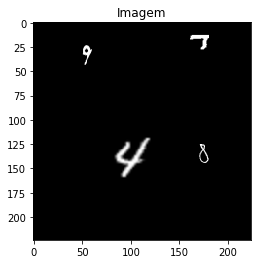

torch.Size([11, 1, 224, 224]) <class 'torch.Tensor'>


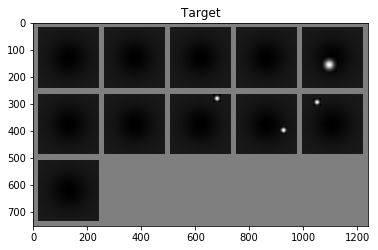

In [5]:
from time import time

creator = CreatorCustomizedMNIST(image_size=(224, 224), digits_count=4)

t = time()
x, y = creator.make_sample()
print(time() - t)

ImageUtil.plot_image(x)
ImageUtil.plot_target(y)

In [6]:
print("CPU count:", mp.cpu_count())

n_sample = 2000
n_created = len(glob.glob("CustomizedMNIST/x/*.png"))
print(n_created)

if n_created >= n_sample:
    print("Dataset already created")
else:
    creator.create(n_sample - n_created)

print(len(glob.glob("CustomizedMNIST/x/*.png")))  

CPU count: 32
0
Generating dataset with 2000 images...
Creating 32 processes...
Process 2: 50/63
Process 1: 50/63
Process 5: 50/63
Process 4: 50/63
Process 3: 50/63
Process 6: 50/63
Process 8: 50/63
Process 7: 50/63
Process 9: 50/63
Process 2 done creating 63 images.
Process 1 done creating 63 images.
Process 10: 50/63
Process 4 done creating 63 images.
Process 3 done creating 63 images.
Process 11: 50/63
Process 5 done creating 63 images.
Process 12: 50/63
Process 8 done creating 63 images.
Process 6 done creating 63 images.
Process 7 done creating 63 images.
Process 9 done creating 63 images.
Process 20: 50/63
Process 13: 50/63
Process 15: 50/63
Process 14: 50/63
Process 10 done creating 63 images.
Process 16: 50/63
Process 17: 50/63
Process 12 done creating 63 images.
Process 11 done creating 63 images.
Process 22: 50/63
Process 19: 50/63
Process 25: 50/63
Process 18: 50/63
Process 13 done creating 63 images.
Process 24: 50/63
Process 21: 50/63
Process 20 done creating 63 images.
Pr

In [7]:
def load_dataset(root='./CustomizedMNIST'):
    x_path = os.path.join(root, "x")
    y_path = os.path.join(root, "y")

    files_x = glob.glob(os.path.join(x_path, "*.png"))
    files_y = glob.glob(os.path.join(y_path, "*.npy"))
    x, y = [], []
    for file_x, file_y in zip(files_x, files_y):
        x.append(cv.imread(file_x, flags=0))
        y.append((np.load(file_y) / 100).astype(np.float))
        
    return train_test_split(x, y, test_size=.2)


class ToTensor(object):
    '''
    Convert dataset output to Tensors.
    '''
    def __call__(self, npimage):
        '''
        input numpy image: H x W
        output torch image: C X H X W
        '''
        return torch.unsqueeze(torch.from_numpy(npimage/255), 0).float()
        
        
class CustomizedMNISTDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
        if self.transform is None:
            self.transform = ToTensor()

            
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, i):
        return self.transform(self.x[i]), self.y[i]

### 2.2 - DataLoaders

In [8]:
batch_size = 32

X_train, X_val, y_train, y_val = load_dataset()
print(X_train[0].shape, X_val[0].shape, y_train[0].shape, y_val[0].shape)

dataset_train = CustomizedMNISTDataset(X_train, y_train)
dataset_val = CustomizedMNISTDataset(X_val, y_val)
print("Len(Train): {}\nLen(Val): {}".format(len(dataset_train), len(dataset_val)))

dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)

(224, 224) (224, 224) (11, 224, 224) (11, 224, 224)
Len(Train): 1612
Len(Val): 404


### 2.3 - Verificando o resultado pelo dataloader

Shapes:  torch.Size([32, 1, 224, 224]) torch.Size([32, 11, 224, 224])
target [min, max] = [0.0, 1.0]


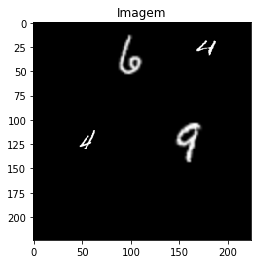

torch.Size([11, 1, 224, 224]) <class 'torch.Tensor'>


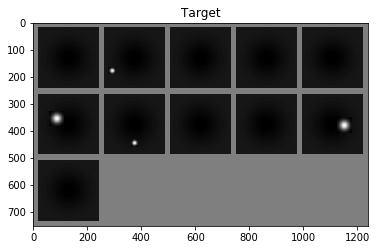

In [9]:
img, target = next(iter(dataloader_train))
print("Shapes: ", img.shape, target.shape)
print("target [min, max] = [{}, {}]".format(target[0].min(), target[0].max()))

ImageUtil.plot_image(img[0].squeeze())
ImageUtil.plot_target(target[0])

## 3 - Modelo Totalmente Convolucional

In [10]:
class MyModelFullyConv(nn.Module):
    def __init__(self):
        super(MyModelFullyConv, self).__init__()
        
        # Camadas convolucionais
        self.conv_layer = nn.Sequential(OrderedDict([
            
            ('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2)),   
            ('relu1', nn.ReLU()),
            
            ('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)),   
            ('relu2', nn.ReLU()),
            
            ('max_pool1', nn.MaxPool2d(2)),
            
            ('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)),
            ('relu3', nn.ReLU()),
            
            ('max_pool2', nn.MaxPool2d(2)),
            
            ('conv4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)),
            ('relu4', nn.ReLU()),
            
            ('conv_t1', nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)),
            ('relu_t1', nn.ReLU()),
            
            ('conv5', nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)),
            ('relu5', nn.ReLU()),
            
            ('conv_t2', nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)),
            ('relu_t2', nn.ReLU()),
            
            ('conv6', nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)),   
            ('relu6', nn.ReLU()),
            
            ('conv7', nn.Conv2d(in_channels=32, out_channels=11, kernel_size=5, padding=2)),   
            
            ('softmax', nn.Softmax2d())
            
        ]))
        
    def forward(self, x):
        x = self.conv_layer(x)        
        return x

### 3.1 - Observando a saida de cada camada

In [11]:
model_conv = MyModelFullyConv().cuda()
x = torch.zeros(1, 1, 300, 300).cuda()

print('{:10}: {}'.format('input', str(x.size())))

for name, layer in model_conv.conv_layer.named_children():
    x = layer(x)
    print('{:10}: {}'.format(name, str(x.size())))
    

input     : torch.Size([1, 1, 300, 300])
conv1     : torch.Size([1, 16, 300, 300])
relu1     : torch.Size([1, 16, 300, 300])
conv2     : torch.Size([1, 32, 300, 300])
relu2     : torch.Size([1, 32, 300, 300])
max_pool1 : torch.Size([1, 32, 150, 150])
conv3     : torch.Size([1, 64, 150, 150])
relu3     : torch.Size([1, 64, 150, 150])
max_pool2 : torch.Size([1, 64, 75, 75])
conv4     : torch.Size([1, 128, 75, 75])
relu4     : torch.Size([1, 128, 75, 75])
conv_t1   : torch.Size([1, 128, 150, 150])
relu_t1   : torch.Size([1, 128, 150, 150])
conv5     : torch.Size([1, 64, 150, 150])
relu5     : torch.Size([1, 64, 150, 150])
conv_t2   : torch.Size([1, 64, 300, 300])
relu_t2   : torch.Size([1, 64, 300, 300])
conv6     : torch.Size([1, 32, 300, 300])
relu6     : torch.Size([1, 32, 300, 300])
conv7     : torch.Size([1, 11, 300, 300])
softmax   : torch.Size([1, 11, 300, 300])


### 3.2 - Fazendo a predição de um batch

In [12]:
x, y = next(iter(dataloader_train))
print("Train shape:", x.shape)

img_pred = model_conv(x.to(device))
print("Pred shape:", img_pred.shape)

prob = img_pred[:1, :, :1, :1]
print("Probabilidade de cada classe em 1px:", prob.shape)
print("Soma: ", torch.sum(prob))

Train shape: torch.Size([32, 1, 224, 224])
Pred shape: torch.Size([32, 11, 224, 224])
Probabilidade de cada classe em 1px: torch.Size([1, 11, 1, 1])
Soma:  tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)


### 3.3 - Função custumizada de Loss

In [13]:
class MyCustomCrossEntropyLoss(nn.modules.loss._Loss):
    
    def __init__(self, size_average=None, reduce=None, reduction='elementwise_mean'):
        super(MyCustomCrossEntropyLoss, self).__init__(size_average, reduce, reduction)
        
    def forward(self, pred, target):
        crossEntropy = (target * torch.log(pred.type(torch.DoubleTensor)).cuda())
        if(self.reduction == 'elementwise_mean'):
            crossEntropy = torch.mean(crossEntropy)
        else:
            crossEntropy = torch.sum(crossEntropy)
        return -crossEntropy

** Testando a função de custo **

In [14]:
x, y = next(iter(dataloader_train))

# print(type(y))
y_pred = model_conv(x.to(device))

loss = MyCustomCrossEntropyLoss()(y_pred, y.cuda())

print(loss)

tensor(0.1684, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)


In [15]:
optm = torch.optim.Adam(params=model_conv.parameters())
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=7, gamma=0.1)
cb_chkpt = ptt.ModelCheckpoint('./last_model', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(model         = model_conv,
                             criterion     = MyCustomCrossEntropyLoss(),
                             optimizer     = optm,
                             lr_scheduler  = schd,
                             callbacks     = [cb_chkpt,
                                              ptt.PrintCallback()],
                             devname       = device)


In [16]:
if True:
    n_epochs = 10
    trainer.fit_loader(n_epochs, dataloader_train, dataloader_val)
else:
    # !wget -nc -q https://www.dropbox.com/s/1xzp51l36spoeta/last_model.model
    trainer.load_state('./last_model')
    trainer.fit_loader(1, dataloader_train, dataloader_val)

Tue Nov 13 03:23:10 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1B.0 Off |                    0 |
| N/A   45C    P0    54W / 300W |   7581MiB / 16160MiB |      8%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:1C.0 Off |                    0 |
| N/A   40C    P0    38W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### 3.4 - Teste do treinamento

Imagem:


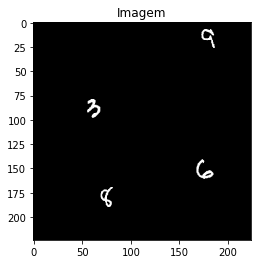

Target:
torch.Size([11, 1, 224, 224]) <class 'torch.Tensor'>


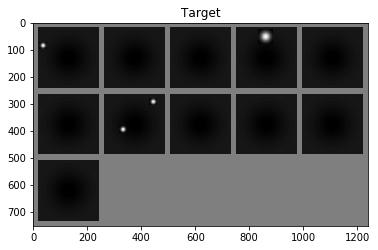

Target Pred.:
torch.Size([11, 1, 224, 224]) <class 'torch.Tensor'>


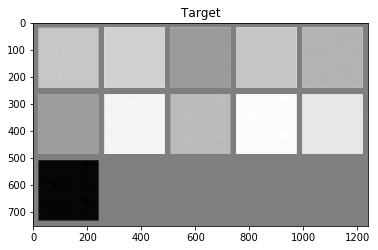

In [19]:
x, y = next(iter(dataloader_val))
pred = model_conv(x.cuda()).cpu().detach()
#pred = pred.data.cpu().numpy()
# ImageUtil.plot_image(img[0].squeeze())
(k, c, w, h) = x.shape

for i in range(k):
    print("Imagem:")
    ImageUtil.plot_image(x[i].squeeze())  
    print("Target:")
    ImageUtil.plot_target(y[i])
    print("Target Pred.:")
    ImageUtil.plot_target(pred[i])
    break;

**Gerando amostras**

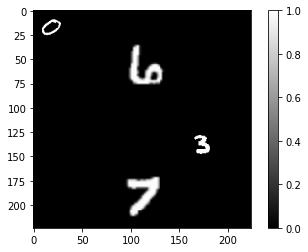

In [38]:
img, _ = next(iter(dataloader_val))
img = img[21].squeeze()
# img = torch.tensor(m_mnist.make_sample()).float()
plt.grid(False)
plt.imshow(img, cmap="gray")
plt.colorbar()

### 4.2 - Output da predição

torch.Size([11, 224, 224])
Imagem:


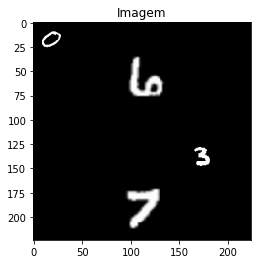

Target Pred.:
torch.Size([11, 1, 224, 224]) <class 'torch.Tensor'>


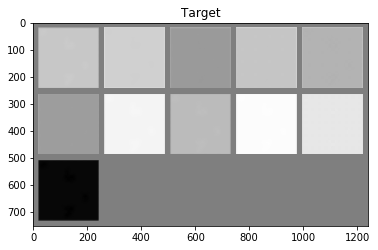

In [39]:
img = torch.tensor(img).float().reshape(1, 1, 224, 224).cuda()
pred = model_conv(img)

print(pred[0].shape)

max_pred, max_class = pred[0][:-1].max(dim=0)

print("Imagem:")
ImageUtil.plot_image(img.cpu().squeeze())  
print("Target Pred.:")
ImageUtil.plot_target(pred.reshape(11, 224, 224).cpu().detach())

### 4.3 - Mapa de calor

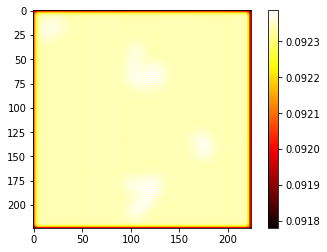

In [40]:
hot_map = max_pred.data.cpu().numpy()
plt.imshow(hot_map.reshape(224, 224), plt.cm.hot)
plt.colorbar()
plt.show()

### 4.4 - Utilizando morfologia para encontrar os BB

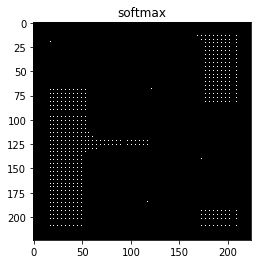

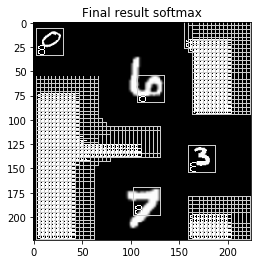

In [48]:
import skimage
from skimage.morphology import square

disk = square(56)
disk[28, 28] = 0
clip = np.clip(hot_map, 0.0, 1.0)
dil = skimage.morphology.dilation(clip, disk)
cc = hot_map >= dil
plt.imshow(cc, cmap="gray")
plt.title(str(name))
plt.show()

new_img = img.cpu().numpy().reshape(224, 224)

for row, col in np.transpose(np.nonzero(cc)):
    cv.rectangle(new_img, (col - 14, row - 14), (col + 14, row + 14), 0.8)
    cv.putText(new_img, str(int(max_class[row, col])), (col - 14, row + 14), cv.FONT_HERSHEY_PLAIN, 1, 1)

plt.grid(False)
plt.imshow(new_img, cmap='gray')  
plt.title("Final result " + str(name))
plt.show()